In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install --upgrade opencv-python

In [3]:
import cv2
print(cv2.__version__)#4.10.0

4.10.0


In [4]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)#2.17.0

2.17.0


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow.keras.preprocessing import image

In [6]:
import tensorflow.keras.backend as K
def check_dir(path):
    if not os.path.exists(path):
        try:
            os.mkdir(path)
        except:
            os.makedirs(path)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator

def load_train_generator(imgs_info='/content/drive/MyDrive/Colab/PHD/data/train.xlsx',imgs_dir='/content/drive/MyDrive/Colab/PHD/data/train',
                         x_col="Image_name", y_cols="Plane", shuffle=False, batch_size=32, seed=1, target_w=256, target_h=256):

    df = pd.read_excel(imgs_info, index_col=0, engine='openpyxl')
    df["Image_name"] = df.index
    df.reset_index(drop=True, inplace=True)
    df.Image_name = imgs_dir + "/" + df.Image_name
    df.Plane.unique()
    df = df.sample(frac=1).reset_index(drop=True)
    df.reset_index(drop=True, inplace=True)

    image_generator = ImageDataGenerator( rotation_range=40,  samplewise_center=False, samplewise_std_normalization=False)

    train_generator=image_generator.flow_from_dataframe(dataframe=df, directory=None, x_col=x_col, y_col=y_cols, subset="training",
        batch_size=batch_size, seed=seed, shuffle=False , class_mode="categorical", target_size=(target_w, target_h))

    return train_generator, df

In [8]:
Train,Train_nor = load_train_generator(imgs_info='/content/drive/MyDrive/Colab/PHD/data/train.xlsx',
                         imgs_dir='/content/drive/MyDrive/Colab/PHD/data/train',x_col="Image_name", y_cols="Plane", shuffle=False,
                         batch_size=32, seed=1, target_w=256, target_h=256)


Valid,Valid_nor = load_train_generator(imgs_info='/content/drive/MyDrive/Colab/PHD/data/valid.xlsx',
                         imgs_dir='/content/drive/MyDrive/Colab/PHD/data/valid',x_col="Image_name", y_cols="Plane", shuffle=False,
                         batch_size=32, seed=1, target_w=256, target_h=256)

Test,test_nor = load_train_generator(imgs_info='/content/drive/MyDrive/Colab/PHD/data/test.xlsx',
                         imgs_dir='/content/drive/MyDrive/Colab/PHD/data/test',x_col="Image_name", y_cols="Plane", shuffle=False,
                         batch_size=1, seed=1, target_w=256, target_h=256)

Found 3408 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.
Found 1122 validated image filenames belonging to 3 classes.


In [9]:
print({
    'train_tt': len([x for x in Train.labels if x == 1]),
    'train_tc': len([x for x in Train.labels if x == 0]),
    'train_tv': len([x for x in Train.labels if x == 2]),

    'val_tt': len([x for x in Valid.labels if x == 1]),
    'val_tc': len([x for x in Valid.labels if x == 0]),
    'val_tv': len([x for x in Valid.labels if x == 2]),

    'test_tt': len([x for x in Test.labels if x == 1]),
    'test_tc': len([x for x in Test.labels if x == 0]),
    'test_tv': len([x for x in Test.labels if x == 2]),
})

{'train_tt': 1136, 'train_tc': 1136, 'train_tv': 1136, 'val_tt': 80, 'val_tc': 80, 'val_tv': 80, 'test_tt': 374, 'test_tc': 374, 'test_tv': 374}


In [10]:
#print("Sample from Train:", Train[0])
#print("Sample from Valid:", Valid[0])

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D,  GlobalAveragePooling2D, Dense,Dropout , Multiply, BatchNormalization,Concatenate
from keras.models import Model
from keras.applications.mobilenet import MobileNet


def attention_block(input_feature):
  attention_feature = Conv2D(128, (1, 1), padding='same', activation='relu')(input_feature)
  attention_feature = Conv2D(32, (1, 1), padding='same', activation='relu')(attention_feature)
  attention_feature = AveragePooling2D(pool_size=(2, 2),strides=(1, 1), padding="same")(attention_feature)
  attention_feature = Conv2D(1, (1, 1), padding='same', activation='relu')(attention_feature)
  return Multiply()([input_feature, attention_feature])

def conv_block(input_feature):
  conv_feature = Conv2D(128, (3, 3), padding='same', activation='relu')(input_feature)
  conv_feature = Conv2D(64, (3, 3), padding='same', activation='relu')(conv_feature)
  conv_feature = MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same")(conv_feature)
  conv_feature = Conv2D(32, (3, 3), padding='same', activation='relu')(conv_feature)
  return conv_feature

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256,256,3))
for layer in base_model.layers:
    layer.trainable = True



input_Net = base_model.input
output_Net = base_model.output
x1 = attention_block(output_Net)
x2 = conv_block(output_Net)
xc = Concatenate()([x1, x2])
xt = Conv2D(128, (3, 3), padding='same', activation='relu')(xc)
x = GlobalAveragePooling2D()(xt)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=input_Net, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', f1_m, precision_m, recall_m])

model.summary()

<ipython-input-11-15558afacf22>:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256,256,3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 128, 128, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 128, 128, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 128, 128, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 128, 128, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 128, 128, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 128, 128, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 129, 129, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 64, 64, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 64, 64, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 64, 64, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 64, 64, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn              │ (None, 64, 64, 128)    │            512 │ conv_pw_2[0][0]        │
│ (BatchNormalization) 

 Total params: 5,869,796 (22.39 MB)

 Trainable params: 5,847,908 (22.31 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.weights.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1, factor=0.1, min_lr=0.000001),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [13]:
history = model.fit(Train, validation_data=Valid, epochs=40, callbacks=callbacks, validation_batch_size=2)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 1060s 9s/step - accuracy: 0.4530 - f1_m: 0.2108 - loss: 1.0360 - precision_m: 0.3593 - recall_m: 0.1706 - val_accuracy: 0.4833 - val_f1_m: 0.4711 - val_loss: 3.0704 - val_precision_m: 0.4737 - val_recall_m: 0.4688 - learning_rate: 0.0010
Epoch 2/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7863 - f1_m: 0.7652 - loss: 0.5846 - precision_m: 0.8232 - recall_m: 0.7182 - val_accuracy: 0.7292 - val_f1_m: 0.7163 - val_loss: 0.8056 - val_precision_m: 0.7480 - val_recall_m: 0.6875 - learning_rate: 0.0010
Epoch 3/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8820 - f1_m: 0.8772 - loss: 0.3542 - precision_m: 0.9086 - recall_m: 0.8489 - val_accuracy: 0.7542 - val_f1_m: 0.7311 - val_loss: 0.8665 - val_precision_m: 0.7444 - val_recall_m: 0.7188 - learning_rate: 0.0010
Epoch 4/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8851 - f1_m: 0.8795 - loss: 0.3206 - precision_m: 0.9077 - recall_m: 0.8537 - val_accuracy: 0.8667 - val_f1_m: 0

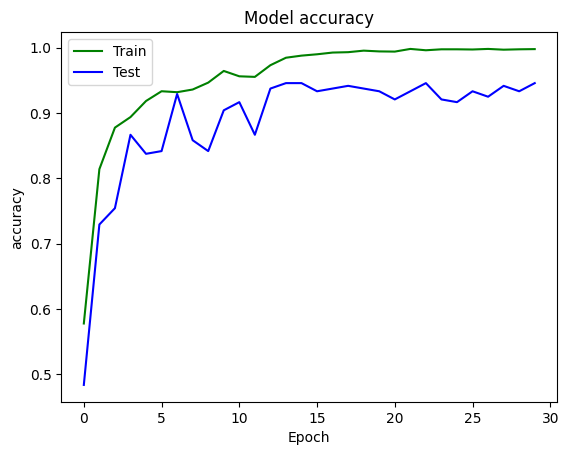

In [14]:
plt.plot(history.history['accuracy'] , color='g')
plt.plot(history.history['val_accuracy'] , color='b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

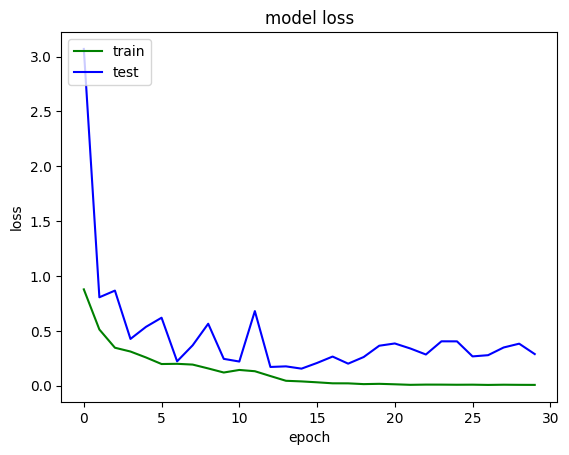

In [15]:
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [16]:
score = model.evaluate(Test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test f1_m:', score[2])
print('Test precision_m:', score[3])
print('Test recall_m:', score[4])

Test loss: 0.23878657817840576
Test accuracy: 0.9402852058410645
Test f1_m: 0.9393938183784485
Test precision_m: 0.9393938183784485
Test recall_m: 0.9393938183784485


In [17]:
from timeit import default_timer as timer

start = timer()
y_hat= model.predict(Test)
print(y_hat.shape)
end = timer()
print(end - start)

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step
(1122, 3)
40.94023832499988


In [18]:
from tensorflow.keras.utils import to_categorical
Labels_test= Test.labels
Labels_test_ = to_categorical(Labels_test, 3)
print(Labels_test_.shape)

(1122, 3)


In [19]:
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay

c_m = confusion_matrix(Labels_test_.argmax(axis=1), y_hat.argmax(axis=1))
print(c_m)

[[361  12   1]
 [ 19 337  18]
 [  3  21 350]]


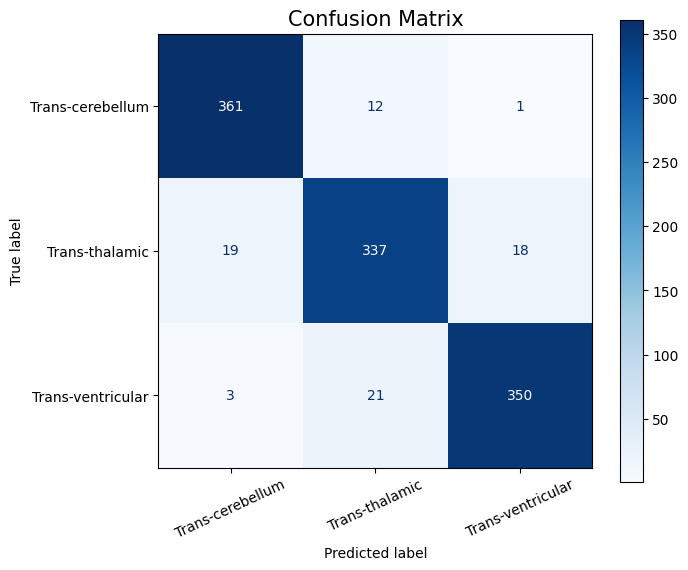

In [20]:
%matplotlib inline

labels = ['Trans-cerebellum','Trans-thalamic', 'Trans-ventricular']
plt.rcParams['figure.figsize'] = (7.0, 6.0)
plt.rcParams['font.size'] = 10
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


display_c_m.plot(cmap='Blues', xticks_rotation=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Confusion Matrix', fontsize=15)
plt.show()

# Heat map with **Grad_CAM**

In [40]:
# Function to generate the Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, class_index):
    last_conv_layer = model.get_layer("conv2d_6" )
    grad_model = tf.keras.models.Model(
        [model.input], [last_conv_layer.output, model.output]    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.array([img_array]))
        class_channel = preds[:, class_index]

    # Compute the gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Apply the gradients to the output of the last conv layer
    heatmap = last_conv_layer_output[0] @ tf.reshape(pooled_grads, (-1, 1))

    # Apply ReLU to the heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

# Function to overlay the heatmap on the original image
def display_heatmap(img_array, heatmap, cam_threshold=0.3):
    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Create a colormap and apply it
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the image
    superimposed_img = heatmap * 0.4 + img_array
    superimposed_img = superimposed_img / superimposed_img.max()  # Normalize for display
    return superimposed_img

# Load and preprocess your image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [41]:
# Parameters
img_path = '/content/drive/MyDrive/Colab/PHD/Patient00644_Plane3_1_of_3.png'
img_array = preprocess_image(img_path)

# Make prediction
predictions = model.predict(img_array)
class_index = np.argmax(predictions[0])  # Find the predicted class index

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, img_array[0], class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Text(0.5, 1.0, 'The Grad-CAM heatmap image')

<Figure size 700x600 with 0 Axes>

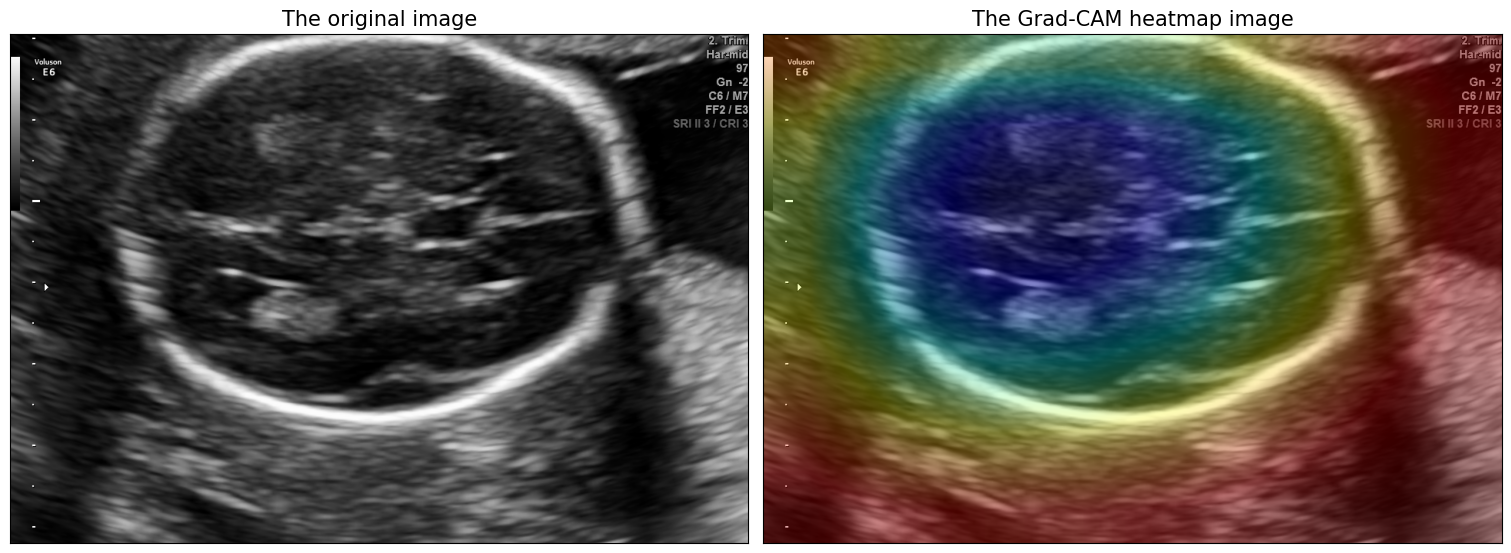

In [42]:
# Display result
original_img = cv2.imread(img_path)
superimposed_img = display_heatmap(original_img, heatmap)

plt.figure()
fig , axarr = plt.subplots(1, 2, figsize=(15, 15),constrained_layout=True, sharey=True,sharex=True)

for ax in axarr:
  ax.set_xticks([])
  ax.set_yticks([])
axarr[0].imshow(original_img)
axarr[0].set_title('The original image', fontdict={'fontsize': 15, 'fontweight': 'medium'})

axarr[1].imshow(superimposed_img)
axarr[1].set_title('The Grad-CAM heatmap image', fontdict={'fontsize': 15, 'fontweight': 'medium'})
